In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from mpl_toolkits.axes_grid1 import ImageGrid
import diverge.output as do

In [3]:
def suscepPlot(mod,out,channel="P",title=""):
    #Channel = "P" "C" or "D"
    no = mod.n_orb
    ns = mod.n_spin
    kmesh = mod.bandstructure[:,-3:]

    ibz_edges = kmesh[::300].T
    ucx, ucy, ucz = mod.lattice.T
    kxv, kyv, kzv = mod.kmesh.T
    kvec = mod.kmesh
    nkx = mod.nk[0]
    nky = mod.nk[1]
    nkz = mod.nk[2]

    # generate real space mesh
    Rx = np.arange(0,nkx,1)
    Ry = np.arange(0,nky,1)
    Rx[Rx>nkx/2-1+1e-5] -= nkx
    Ry[Ry>nky/2-1+1e-5] -= nky

    Rx, Ry = np.meshgrid(Rx,Ry)
    R1 = np.ndarray.flatten(Rx)
    R2 = np.ndarray.flatten(Ry)

    uc1 = np.array([ucx[0],ucy[0],ucz[0]])
    uc2 = np.array([ucx[1],ucy[1],ucz[1]])
    FFT_realspace_vectors = uc1[:,None]*R1[None,:] + uc2[:,None]*R2[None,:]
    

    exponential = np.exp(1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,kvec)) #this is for the Fourier transform somehow?

    if channel == "P":
        susz = out.Psusc
    elif channel == "C":
        susz = out.Csusc
    elif channel == "D":
        susz = out.Dsusc
    else:
        print("Invalid channel")
        return
    
    susz = np.einsum('abcdabcdk->bdk',susz)
    func_R = np.einsum('...k,rk->...r',susz,exponential)
    #generate target mesh
    N_segment = 300
    ibz_path = np.zeros((N_segment*(ibz_edges.shape[1]-1),3))
    steps = np.linspace(0,1,N_segment)

    for edge in range(1,ibz_edges.shape[1]):
        ibz_path[(edge-1)*N_segment:edge*N_segment,:] = (1.-steps[:,None])*ibz_edges[:,edge-1][None,:] + steps[:,None] * ibz_edges[:,edge][None,:]


    steps = np.linspace(0,1,N_segment*(ibz_edges.shape[1]-1))
    exponential = np.exp(-1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,ibz_path))

    ibz_susz = np.einsum('...r,rk->k...',func_R,exponential)/len(kxv)

    k_idx = []
    where_on_path = []
    for i in range(len(kxv)):
        diff_to_all = np.linalg.norm(kvec[i,:][:,None]-ibz_path.transpose(), axis = 0)
        if(np.min(diff_to_all) < 12./N_segment):
            k_idx.append(i)
            where_on_path.append(np.argmin(diff_to_all))

    where_on_path = np.asarray(where_on_path)
    k_idx = np.asarray(k_idx)

    perm = where_on_path.argsort()
    where_on_path = where_on_path[perm]
    k_idx = k_idx[perm]

    lines_maker1 =[]
    fig = plt.figure(figsize=(4.2,3.15))
    ax = fig.add_subplot(111)
    orbc = ["1z2"]
    colors= ["purple"]
    for i in range(no):
        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,i]))) #lines_maker1.append(line2[0])
        ax.plot(steps[where_on_path],np.abs(np.real(susz[i,i, k_idx])),color =
                    "black",marker=".",linestyle="None")

    #ax.scatter(steps,dx2y2,c="black",marker="o")

  
    #lines_maker1.append(line2[0])
    #ax.plot(steps[where_on_path],np.abs(np.real(susz[i,i, k_idx])),color =
    #        "black",marker=".",linestyle="None")
            

    #for i in range(no):
    #    for j in range(0,i):
    #        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,j])),linestyle = "--", label = orbc[i]+";"+orbc[j])
    #        lines_maker1.append(line2[0])

    if channel == "P":
        plt.title("SC susceptibility "+title)
    elif channel == "C":
        plt.title("SDW susceptibility "+title)
    elif channel == "D":
        plt.title("CDW susceptibility "+title)
    else:
        plt.title("suscep? "+title)
    ax.set_ylabel(r"$\chi$")
    
    xticks = []
    xticklabels = []
    for i in range(ibz_edges.shape[1]-1):
        ax.axvline(steps[i*N_segment], color="black", lw=0.5, linestyle="--")
        xticks.append(steps[i*N_segment])
        xticklabels.append(i)
    #final line
    ax.axvline(steps[-1], color="black", lw=0.5, linestyle="--")
    xticks.append(steps[-1])
    xticklabels.append(ibz_edges.shape[1])


    ax.set_xticks(xticks)
    if len(mod.klabels) == len(xticks):
        ax.set_xticklabels(mod.klabels)
    else:
        ax.set_xticklabels(xticklabels)
    
    ax.set_xlabel(r"$\mathbf{q}$")

    ax.set_yticklabels([])  # Hide the tick labels
    ax.yaxis.set_ticks_position('none')



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os  # for directory management

# Ensure the folder exists
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)

mu = "1.00"
Uvals = np.arange(1, 21, 1)
Uvals_str = [f"{value:.2f}" for value in Uvals]

for i, u in enumerate(Uvals_str):
    
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

    # Plotting
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")

    # Save the plot
    plot_filename = os.path.join(output_folder, f"suscep_plot_U_{u}_mu_{mu}.png")
    plt.savefig(plot_filename)
    plt.close()  # Close the plot to avoid overlap with the next one



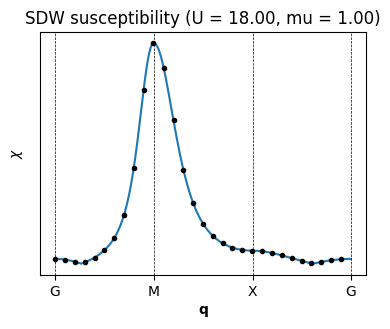

In [5]:
nk = 20
nkf = 5
u = "18.00"
mu = "1.00"

ff = "4.00"
mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
mod.klabels = ["G", "M", "X", "G"]

out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

suscepPlot(mod, out, channel="C", title=f"(U = {u}, mu = {mu})")

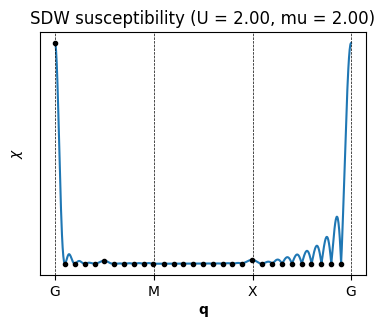

In [6]:
nk = 20
nkf = 5
u = "2.00"
mu = "2.00"

ff = "4.00"
mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
mod.klabels = ["G", "M", "X", "G"]

out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

suscepPlot(mod, out, channel="C", title=f"(U = {u}, mu = {mu})")

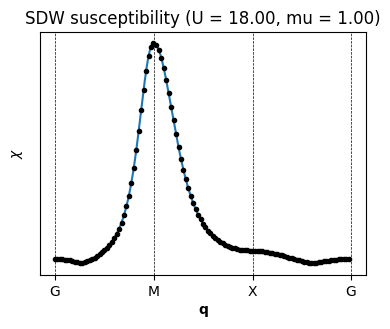

In [7]:
nk = 80
nkf = 5
u = "18.00"
mu = "1.00"

ff = "4.00"
mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
mod.klabels = ["G", "M", "X", "G"]

out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")


suscepPlot(mod, out, channel="C", title=f"(U = {u}, mu = {mu})")

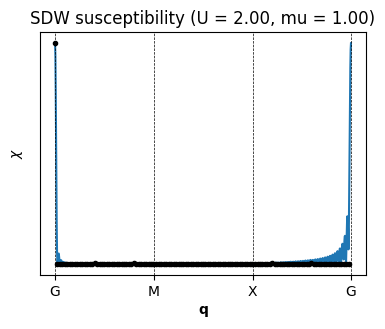

In [9]:
nk = 80
nkf = 5
u = "2.00"
mu = "1.00"

ff = "4.00"
mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
mod.klabels = ["G", "M", "X", "G"]

out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")


suscepPlot(mod, out, channel="C", title=f"(U = {u}, mu = {mu})")